In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
def note_freqs(n):
    return 440 * 2**(n/12)

def idx_for_freq(f):
    hz_per_bin = 10.7666015625
    return int((f + hz_per_bin) / hz_per_bin)

In [3]:
files = ["c_major", "c_minor", "c_major_5", "c_major_3"]
data = []
for file in files:
    with open("data_{}.csv".format(file)) as f:
        dump = f.readlines()
        series = [[int(num) for num in dump[i].split(",")] for i in range(len(dump))]
        data.append(series)

In [4]:
print(len(data), len(data[0]), len(data[0][0]))

4 20 2048


In [75]:
# not needed ....
def convolve(arr):
    res = []
    width = 2
    for i in range(width):
        res.append(0)
    def shape(i):
        return [0.1, 0.5, 1, 0.5, 0.1][i]
    for i in range(width, len(arr)-width):
        r = 0
        for j in range(0, 2*width+1):
            r += shape(j) * arr[i-width+j]
        r /= 2.2
        res.append(r)
    return res

<IPython.core.display.Javascript object>


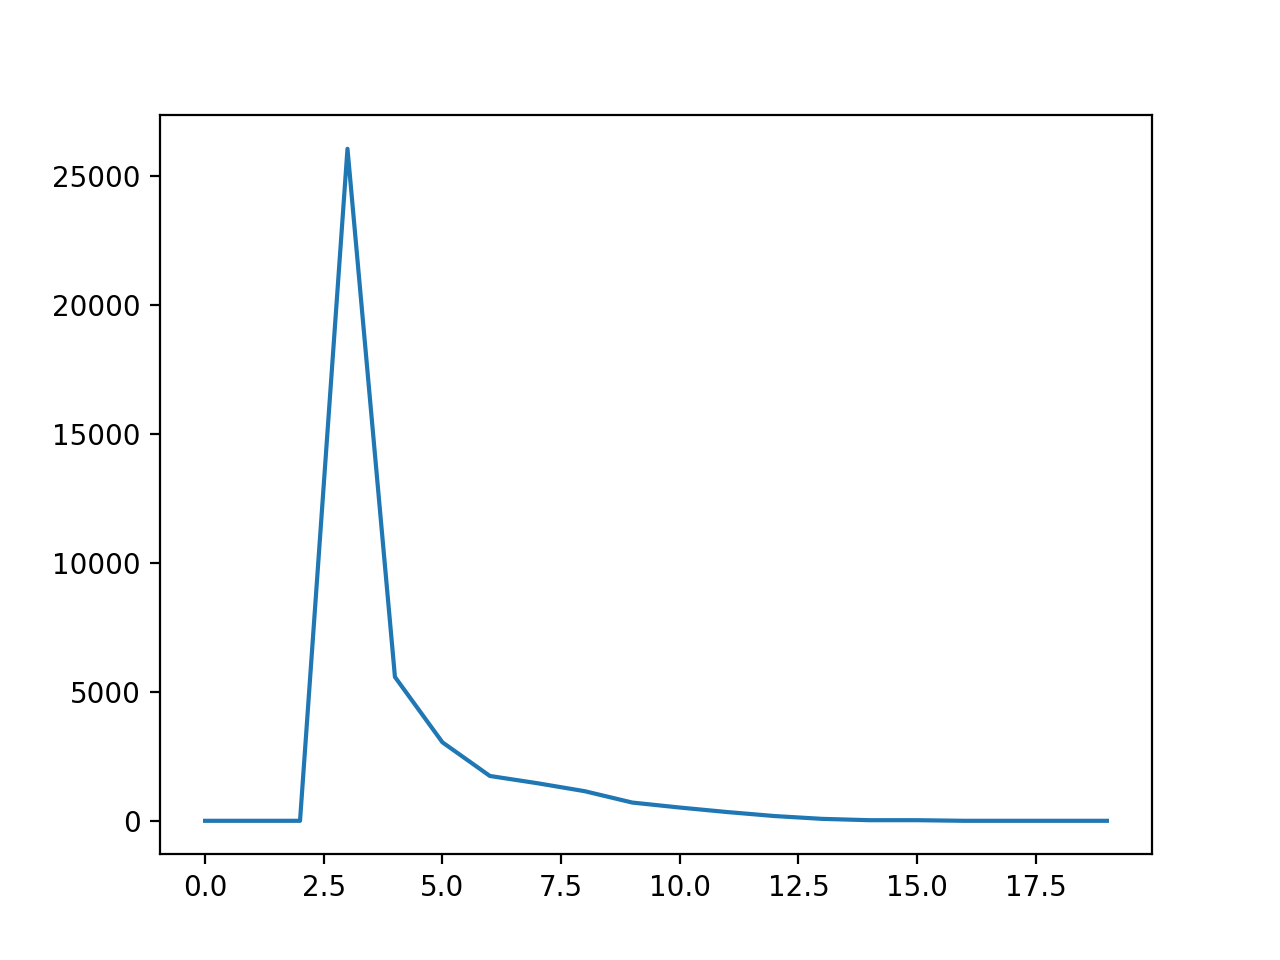

In [5]:
series = data[0]

total = [sum(spec) for spec in series]

plt.plot(total)
plt.show()

<IPython.core.display.Javascript object>


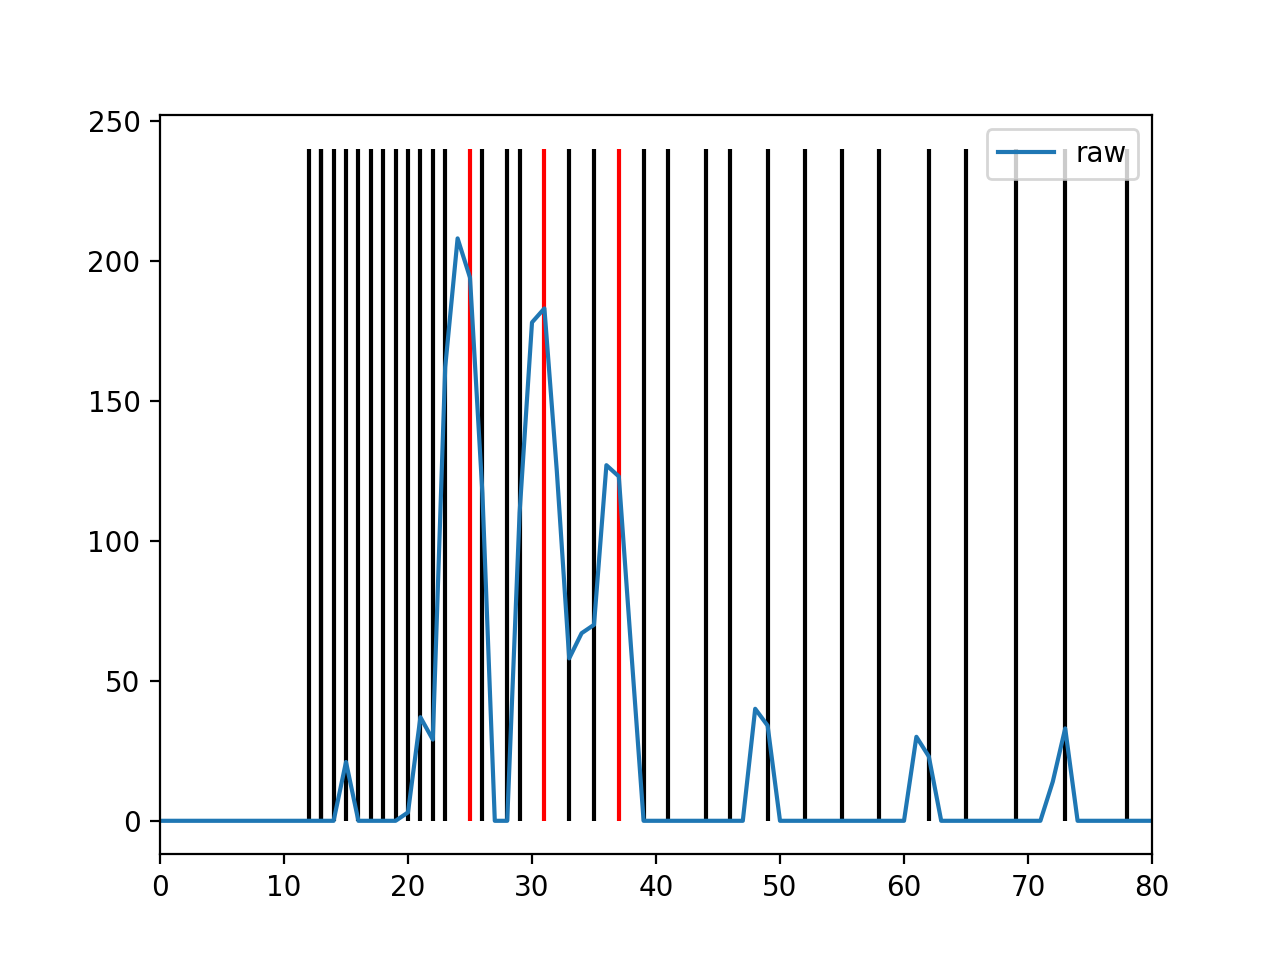

-9 25
-5 31
-2 37


In [10]:
for n in range(-22, 88-5*12):
    chord = [-9, -9+4, -9+4+3]
    chord = [c for c in chord]
    col = "k"
    if n in chord:
        col = "r"
        print(n, idx_for_freq(note_freqs(n)))
    plt.vlines(x=idx_for_freq(note_freqs(n)), ymin=0, ymax=240, color=col)
    
idx = 5

plt.plot(series[idx], label="raw")
# plt.plot(convolve(series[idx]))
plt.xlim([0, 80])
plt.legend()
plt.show()

## Notes

### Detect peaks
- simple a < b > c wont work...
  - need to use a convolution
  - convolution should be short and fall rapidly. maybe use 5 non-zero bins, with very steep gaussian
  
### Detect play
- total power spectrum has VERY noticable bump (!)
  - can probably just detect rising edges like that (where we go from 0 to > 5k or so ...)
  
### Detecting if note is played
- if it has consistently high power this is a good predictor
- (high power is power > 50 & > average (?))
- if the power is monotonously falling starting from the beginning, this is a good predictor

### Buffer length
- a 3 frame buffer should be enough (3/10 second response time, which is good(!)
- we only need to know the previous

### Overtones vs note:
- the high sample has the following problem: highest note is detected one octave too high
  - maybe there could be a rule that favours notes close to the global max?
- will include rule to surpress outlies, as that works much better with piano
  
### Note on C3 and below:
this is probably to low for us to resolve well with our transform

In [20]:
# probability distributions

# on means power should be high
def prob_power_on(p, p_avg, p_max, lam=1):
    return lam * np.exp(-lam*(p_max-p)/p_avg)

def prob_power_off(p, p_avg, p_max, lam=1):
    return lam * np.exp(-lam*(p/p_avg))

# monotonus decrease was a fad ...

# is local max
def prob_max_on(p, p_l_max, lam=1):
    return lam * np.exp(-lam*abs(p-p_l_max))

def prob_max_off(p, p_l_max, lam=1):
    if p_l_max == p:
        return lam
    return lam * np.exp(-lam*1/abs(p-p_l_max))

# is proximal to global max (hands are not huge!)
# does what it should, but not very helpful ...
def prob_g_max_on(n, n_max, lam=0.5, m=5):
    return lam * np.exp(-lam*abs(n_max-n)/m)

def prob_g_max_off(n, n_max, lam=0.5, m=5):
    if n_max == n:
        return lam
    return lam * np.exp(-lam*m/abs(n_max-n))

def prob_on(p, p_avg, p_max, p_l_max, n, n_max):
    return prob_power_on(p, p_avg, p_max) * prob_max_on(p, p_l_max) * prob_g_max_on(n, n_max)

def prob_off(p, p_avg, p_max, p_l_max, n, n_max):
    return prob_power_off(p, p_avg, p_max) * prob_max_off(p, p_l_max) * prob_g_max_off(n, n_max)

<IPython.core.display.Javascript object>


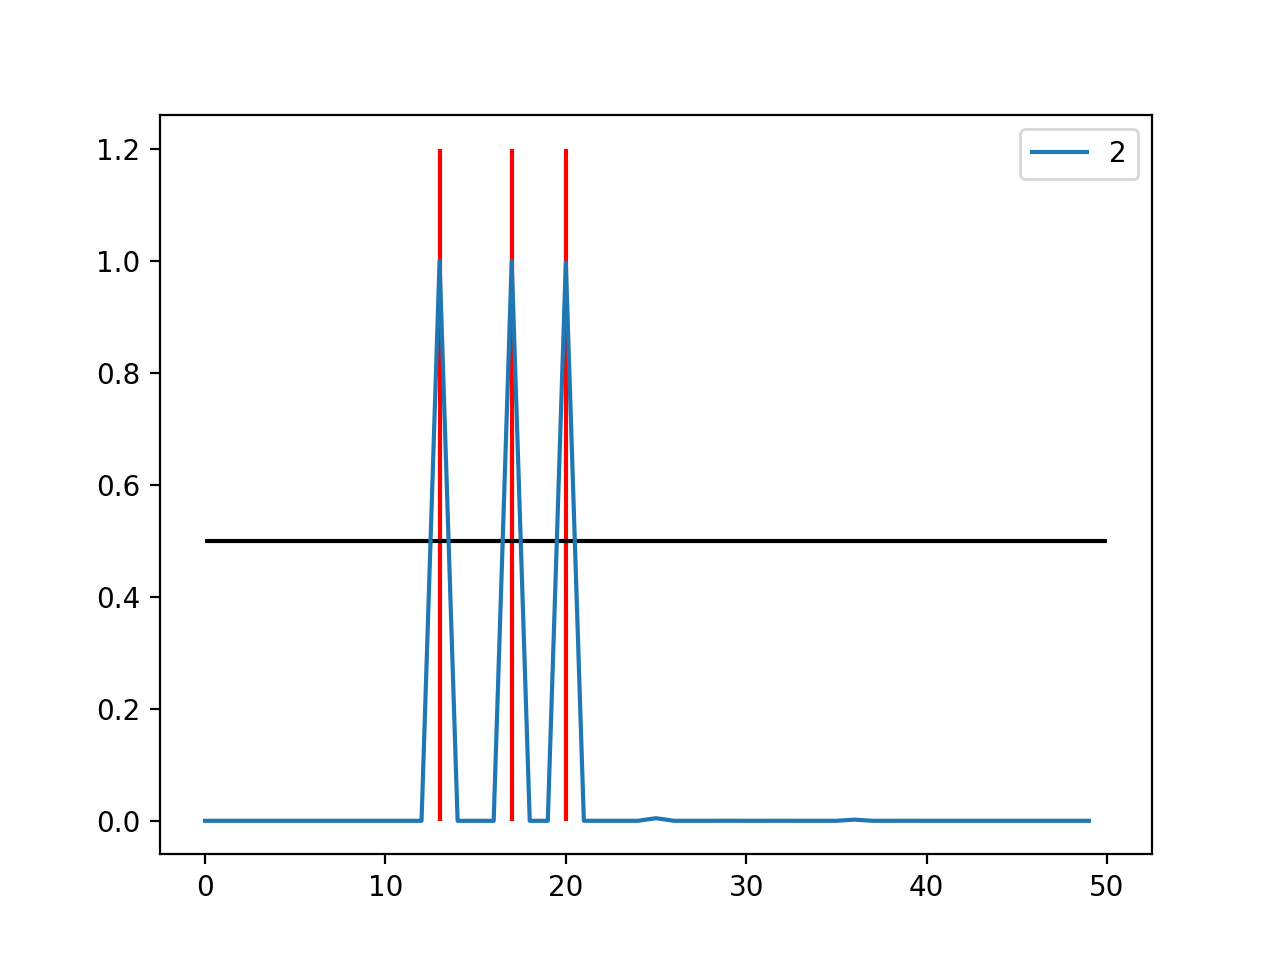

In [24]:
# Algorithm sketch

buffer = []
notes = [idx_for_freq(note_freqs(n)) for n in range(-22, 88-5*12)] # from lowest possible, to highest piano key
total_prev = 0

in_stream = data[0] # fake audio input stream
want = [22-9, 22-9+4, 22-9+7]
want = [c for c in want]

for frame in in_stream:
    total = sum(frame)
    if total > 2*total_prev:
        # start!
        buffer.append([frame[i] for i in notes])
        if len(buffer) == 3: # n frame buffer
            break
            
# do bayes analysis
prob = [0.5 for _ in range(-22, 88-5*12)]

for idx in range(0, len(buffer)):
    p_max = max(buffer[idx])
    p_avg = sum(buffer[idx]) / len(buffer[idx])
    n_max = 0
    for n in range(0, len(buffer[idx])):
        if buffer[idx][n] == p_max:
            n_max = n
    for n in range(0, len(buffer[idx])):
        p = buffer[idx][n]
        p_l_max = max( buffer[idx][max(n-1, 0):min(n+2, len(buffer[idx]))] )
        p_given_on = prob_on(p, p_avg, p_max, p_l_max, n, n_max)
        p_given_off = prob_off(p, p_avg, p_max, p_l_max, n, n_max)
        # update
        prob[n] = prob[n] * p_given_on / (prob[n]*p_given_on + (1-prob[n])*p_given_off)
        
plt.plot(prob, label=idx)
plt.legend()
for i in want:
    plt.vlines(x=i, ymin=0, ymax=max(prob)+0.2, color="r")
plt.hlines(y=0.5, xmin=0, xmax=len(prob))
#plt.plot(buffer[2])
plt.show()